# Reinforcement Learning (Q-Learning) for solving Cartpole

The goal is to move the cart so that the pole stays balanced. And a big problem here is that there isn't a discrete number of states. Because the cart can stay on multiple positions from -4.8 to 4.8 and with infinite between values.

Action space is very simple: push car left or push car right

to solve:

from continous state-space **to** discrete state-space

state-space or observation-space

reminder: 
- a **state** contains all information about the environment
- a **observation** contains a set of information about the environment (can contains all, then its like a state)

**imports**

In [1]:
%matplotlib notebook
import time
import gym

import numpy as np
import matplotlib.pyplot as plt

**env exploration**

In [2]:
env = gym.make('CartPole-v1')

env.reset()

for step in range(2):
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    if done:
        break

    #time.sleep(0.03)

env.close()

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
observation

array([-0.02266203, -0.37836283, -0.02658591,  0.56688344], dtype=float32)

=> cart position, cart velocity, pole angle, angular velocity

**solve continoues observation-space-problem**

we have to bin the continous space in discrete space

steps:
- decide on number of total states
- quantify range for continous values
- create placeholder arrays
- create function for placing continoues value into defined bin in placeholder array

In [4]:
def create_bins(num_bins_per_obs=10):

    # BINNING CART_POSITION
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_obs)

    # BINNING CART_VELOCITY
    # to choose which numbers for -inf to inf -> you have to play it and choose a range
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_obs)

    # BINNING POLE ANGLE
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_obs)

    # BINNING ANGULAR VELOCITY
    bins_angular_velocity = np.linspace(-5, 5, num_bins_per_obs)

    bins = np.array([bins_cart_position,
                    bins_cart_velocity,
                    bins_pole_angle,
                    bins_angular_velocity])

    return bins

In [5]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)
BINS

array([[-4.8       , -3.73333333, -2.66666667, -1.6       , -0.53333333,
         0.53333333,  1.6       ,  2.66666667,  3.73333333,  4.8       ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ],
       [-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
         0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ]])

binning index

In [6]:
def discretize_observations(observations, bins):
    binned_observations = []

    for obs_idx, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[obs_idx])
        binned_observations += [discretized_observation]

    return tuple(binned_observations)

testing

In [7]:
observations = env.reset()
observations

array([-0.00858256,  0.03337753, -0.01270899,  0.02521794], dtype=float32)

In [8]:
mapped_observations = discretize_observations(observations, BINS)
mapped_observations

(5, 5, 5, 5)

=> all are in the middle of the bins -> 0-10, which is at the start normal

**q table set up**

In [9]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table_shape

(10, 10, 10, 10, 2)

In [10]:
q_table = np.zeros(q_table_shape)

**hyperparameter**

In [11]:
# how many times the agent plays the game
EPOCHS = 20000 # Episodes

# learning rate
ALPHA = 0.8

# discount-rate
# should be a little smaller than 1
GAMMA = 0.9

In [12]:
# eploration vs exploitation params

# eploration rate
epsilon = 1.0
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

**defining update functions**

In [13]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()

    # EXPLOTATION (choose the action that maximizes Q)
    if random_number > epsilon:
        action = np.argmax(q_table[discrete_state])

    # EXPLORATION (choose a random action)
    else:
        # Return a random 0, 1, 2, 3 action
        #action = env.action_space.sample()
        action = np.random.randint(0, env.action_space.n)
    return action

In [14]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA*next_optimal_q_value - old_q_value)

In [15]:
def reduce_epsilon(epsilon, epoch):
    # linear reducing epsilon within a threshold of time
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

In [16]:
# reward is in this environment not good
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

**agent training**

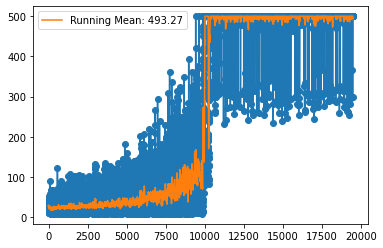

In [17]:
%matplotlib inline

env = gym.make('CartPole-v1')
q_table = np.zeros(q_table_shape)

should_render = False 

####### VISUALIZATION #######
log_interval = 500
render_interval = 30000    # set like you will

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
#############################

points_log = []
mean_points_log = []
epochs = []

#############################

for epoch in range(EPOCHS):
    initial_state = env.reset()
    discretized_state = discretize_observations(initial_state, BINS)
    done = False
    points = 0

    # PLAY GAME
    while not done:
        if should_render:
            env.render() 

        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        try:
            next_state, reward, done, info = env.step(action)
        except AssertionError as e:
            print(f"Error by action: {action}")
            raise e

        reward = fail(done, points, reward)

        next_state_dicretized = discretize_observations(next_state, BINS)

        old_q_value = q_table[discretized_state + (action, )]
        #print(old_q_value)
        next_optimal_q_value = np.max(q_table[next_state_dicretized])

        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discretized_state + (action, )] = next_q

        # setup for next round
        discretized_state = next_state_dicretized
        points += 1

        if should_render:
            time.sleep(0.03)

    epsilon = reduce_epsilon(epsilon, epoch)
    points_log += [points]
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log += [running_mean]
    epochs += [epoch]

    #############################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f'Running Mean: {running_mean}')
        plt.legend()
        fig.canvas.draw()

env.close()

**use agent**

In [20]:
env = gym.make('CartPole-v1')

observation = env.reset()
rewards = 0

for step in range(1000):
    env.render()
    discrete_state = discretize_observations(observation, BINS)
    action = np.argmax(q_table[discrete_state])
    observation, reward, done, info = env.step(action)
    rewards += 1

    #time.sleep(0.03)

    if done:
        print(f"You got {rewards} points!")
        break

env.close()

You got 500 points!


In [39]:
import gym
from gym.utils.play import play

points = 0

def info(obs_t, obs_tp1, action, rew, done, info):
    global points 
    points += 1
    if done:
        print(f"You got {points} points!")
        points = 0

#play(gym.make("CartPole-v1"), keys_to_action={"a": 0, "d": 1}, callback=info)

You got 9 points!
You got 10 points!
You got 8 points!
You got 36 points!
You got 11 points!
You got 15 points!
You got 16 points!
You got 21 points!
You got 11 points!
You got 31 points!
You got 18 points!
You got 10 points!
You got 9 points!
You got 10 points!
You got 10 points!
You got 9 points!
You got 9 points!
You got 9 points!
You got 10 points!
You got 10 points!
You got 8 points!
